In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
import torch.utils.data as data
import torch.utils.data.sampler as sampler
from torch.utils.tensorboard import SummaryWriter
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import network
import mnist_loader

train_loader, validation_loader, test_loader = mnist_loader.load_data()

print(len(validation_loader.dataset))

torch.cuda.is_available()

10000


True

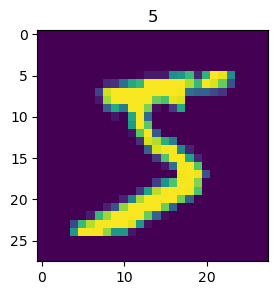

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
plt.title(f"{train_loader.dataset[0][1]}")
plt.imshow(train_loader.dataset[0][0][0])
plt.show()

In [4]:
# model accuracy check
def accuracy(output, target):
    return sum([torch.argmax(o) == t for o, t in zip(output, target)]), len(target)

## Network 1
Simple network with 3 fully connected layers. Sigmoid activation function. Cross Entropy Loss function.

In [5]:
eta = 0.3
epochs = 10

net1 = network.Network1()
print(net1)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net1.parameters(), lr=eta)
net1.zero_grad()

val_accs = []
val_loss = []
train_accs = []
train_loss = []

for epoch in range(epochs):
    print(f"epoch {epoch}")
    
    total_loss = 0.
    total_acc = (0, 0)
    
    for i, (X, y) in enumerate(train_loader):
        net1.train() # training mode
        
        output = net1(X)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_acc = tuple(a + b for a, b in zip(total_acc, accuracy(output, y)))
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 0: # for every 100th batch
            net1.eval() # evaluation mode
            with torch.no_grad():
                total_val_loss = 0.
                val_acc = (0, 0)
                for j, (val_X, val_y) in enumerate(validation_loader):
                    # evaluation loss and accuracy check
                    output = net1(val_X)
                    val_acc = tuple(a + b for a, b in zip(val_acc, accuracy(output, val_y)))
                    total_val_loss += criterion(output, val_y).item()
                print(f" evaluation accuracy: {100 * val_acc[0] / val_acc[1]}")
                val_accs.append(val_acc)
                val_loss.append(total_val_loss / len(validation_loader))
    
    print(f" training accuracy: {100 * total_acc[0] / total_acc[1]}")
    train_accs.append(total_acc)
    train_loss.append(total_loss / len(train_loader))

Network1(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
epoch 0
 evaluation accuracy: 10.0
 evaluation accuracy: 10.0
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 9.239999771118164
 evaluation accuracy: 18.84000015258789
 evaluation accuracy: 10.600000381469727
 training accuracy: 12.466666221618652
epoch 1
 evaluation accuracy: 17.299999237060547
 evaluation accuracy: 29.040000915527344
 evaluation accuracy: 31.579999923706055
 evaluation accuracy: 39.380001068115234
 evaluation accuracy: 52.0
 evaluation accuracy: 59.34000015258789
 training accuracy: 43.29499816894531
epoch 2
 evaluation accuracy: 62.18000030517578
 evaluation accuracy: 59.58000183105469
 evaluation accuracy: 59.97999954223633
 evaluation accuracy: 58.880001068115234
 evaluation accuracy: 59.65999984741211
 evaluation accuracy: 59.41999816894531
 training accu

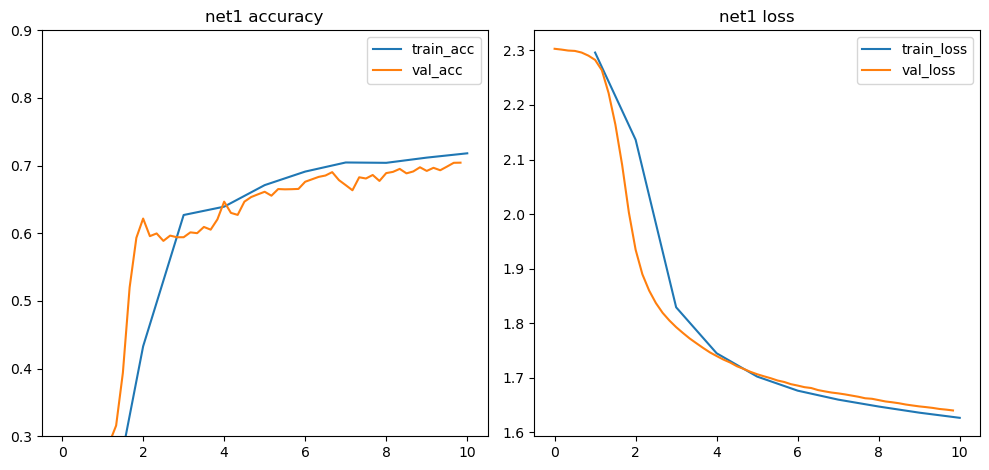

final loss: train 1.626264436841011 v eval 1.6397700803518296
final acc: train 0.7182333469390869 v eval 0.7044000029563904


In [6]:
fig, ax = plt.subplots(1, 2)
eval_per_epoch = 6

ax[0].plot(range(1, epochs+1), [train_acc[0] / train_acc[1] for train_acc in train_accs], label='train_acc')
ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [val_acc[0] / val_acc[1] for val_acc in val_accs], label='val_acc')
ax[0].set_ylim(0.3, .9)
ax[0].set_title('net1 accuracy')
ax[0].legend()

ax[1].plot(range(1, epochs+1), train_loss, label='train_loss')
ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], val_loss, label='val_loss')
ax[1].set_title('net1 loss')
ax[1].legend()

fig.set_figwidth(10)

plt.tight_layout()
plt.show()

final_acc = (train_accs[-1], val_accs[-1])
final_loss = (train_loss[-1], val_loss[-1])

print(f"final loss: train {final_loss[0]} v eval {final_loss[1]}")
print(f"final acc: train {final_acc[0][0] / final_acc[0][1]} v eval {final_acc[1][0] / final_acc[1][1]}")

In [8]:
with torch.no_grad():
    test_acc = (0, 0)
    for j, (test_X, test_y) in enumerate(test_loader):
        # evaluation loss and accuracy check
        output = net1(test_X)
        test_acc = tuple(a + b for a, b in zip(test_acc, accuracy(output, test_y)))

print(f" test accuracy: {100 * test_acc[0] / test_acc[1]}")

 test accuracy: 74.58000183105469


Terrible results, even if its only 10 epochs. Actually loses accuracy at a certain point?

## Network 2
Network 1, but with ReLU activation instead of sigmoid.

In [7]:
eta = 0.1
epochs = 20

# Create a SummaryWriter instance
writer = SummaryWriter()

net2 = network.Network2()
print(net2)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net2.parameters(), lr=eta)
net2.zero_grad()

val_accs = []
val_loss = []
train_accs = []
train_loss = []
    
total_loss = 0.
total_acc = (0, 0)

for epoch in range(epochs):
    print(f"epoch {epoch}")
    
    for i, (X, y) in enumerate(train_loader):
        net2.train() # training mode
        
        output = net2(X)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_acc = tuple(a + b for a, b in zip(total_acc, accuracy(output, y)))
        
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 99: # for every 100th batch
            net2.eval() # evaluation mode
            
            with torch.no_grad():
                total_val_loss = 0.
                val_acc = (0, 0)
                for j, (val_X, val_y) in enumerate(validation_loader):
                    # evaluation loss and accuracy check
                    output = net2(val_X)
                    val_acc = tuple(a + b for a, b in zip(val_acc, accuracy(output, val_y)))
                    total_val_loss += criterion(output, val_y).item()
                print(f" evaluation accuracy: {100 * val_acc[0] / val_acc[1]}")
                val_accs.append(val_acc)
                val_loss.append(total_val_loss / len(validation_loader))
                
            print(f" training accuracy: {100 * total_acc[0] / total_acc[1]}")
            train_accs.append(total_acc)
            train_loss.append(total_loss / 100)
                        
            # Log scalar values
            writer.add_scalars('Net2 Loss', {'train': total_loss / 100, 'val': total_val_loss / len(validation_loader)}, epoch * len(train_loader) + i)
            writer.add_scalars('Net2 Acc', {'train': total_acc[0] / total_acc[1], 'val': val_acc[0] / val_acc[1]}, epoch * len(train_loader) + i)
            
            total_loss = 0.
            total_acc = (0, 0)
    

Network2(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
epoch 0
 evaluation accuracy: 51.68000030517578
 training accuracy: 43.869998931884766
 evaluation accuracy: 54.81999969482422
 training accuracy: 53.290000915527344
 evaluation accuracy: 57.060001373291016
 training accuracy: 55.959999084472656
 evaluation accuracy: 56.79999923706055
 training accuracy: 56.31999969482422
 evaluation accuracy: 56.779998779296875
 training accuracy: 57.06999969482422
 evaluation accuracy: 57.7599983215332
 training accuracy: 56.81999969482422
epoch 1
 evaluation accuracy: 57.619998931884766
 training accuracy: 56.93000030517578
 evaluation accuracy: 58.13999938964844
 training accuracy: 57.849998474121094
 evaluation accuracy: 57.91999816894531
 training accuracy: 58.2599983215332
 evaluation accuracy: 58.040000915527344
 training accuracy: 57.540000915527344


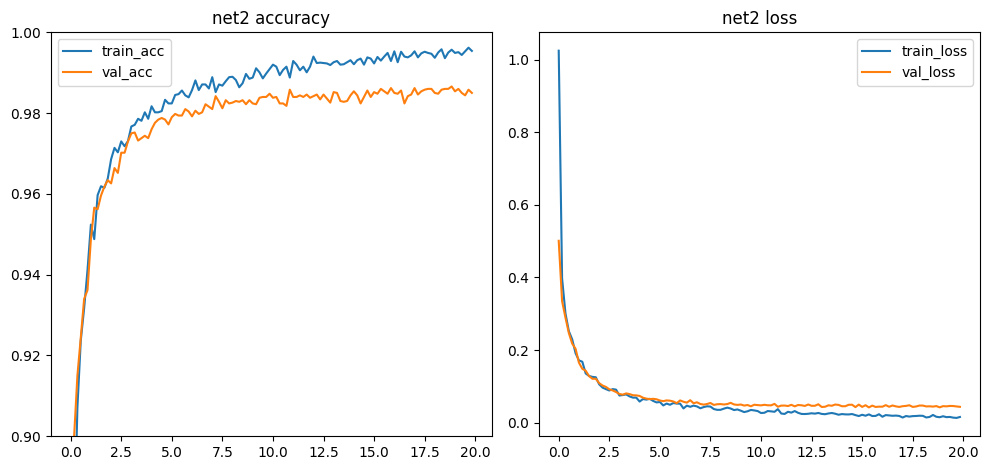

final loss: train 0.01563635143917054 v eval 0.04361853270881166
final acc: train 0.9954000115394592 v eval 0.9850000143051147


In [16]:
fig, ax = plt.subplots(1, 2)
eval_per_epoch = 6

ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [train_acc[0] / train_acc[1] for train_acc in train_accs], label='train_acc')
ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [val_acc[0] / val_acc[1] for val_acc in val_accs], label='val_acc')
ax[0].set_ylim(0.9, 1.0)
ax[0].set_title('net2 accuracy')
ax[0].legend()

ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], train_loss, label='train_loss')
ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], val_loss, label='val_loss')
ax[1].set_title('net2 loss')
ax[1].legend()

fig.set_figwidth(10)

plt.tight_layout()
plt.show()

final_acc = (train_accs[-1], val_accs[-1])
final_loss = (train_loss[-1], val_loss[-1])

print(f"final loss: train {final_loss[0]} v eval {final_loss[1]}")
print(f"final acc: train {final_acc[0][0] / final_acc[0][1]} v eval {final_acc[1][0] / final_acc[1][1]}")

In [10]:
with torch.no_grad():
    test_acc = (0, 0)
    for j, (test_X, test_y) in enumerate(test_loader):
        # evaluation loss and accuracy check
        output = net2(test_X)
        test_acc = tuple(a + b for a, b in zip(test_acc, accuracy(output, test_y)))

print(f" test accuracy: {100 * test_acc[0] / test_acc[1]}")

 test accuracy: 60.599998474121094


Testing accuracy is abysmal. Severe overfitting happening.

## Network 3
1 Convolutional layer, 2 fully connected layers.

In [11]:
eta = 0.1
epochs = 20
l2_lambda = 0.01
dropout = 0.2

# Create a SummaryWriter instance
writer = SummaryWriter()

net3 = network.Network3(dropout=dropout)
print(net3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net3.parameters(), lr=eta)
net3.zero_grad()

val_accs = []
val_loss = []
train_accs = []
train_loss = []
    
total_loss = 0.
total_acc = (0, 0)

layers_to_regularize = [net3.conv, net3.fc1]

for epoch in range(epochs):
    print(f"epoch {epoch}")
    
    total_loss = 0.
    total_acc = (0, 0)
    
    for i, (X, y) in enumerate(train_loader):
        net3.train() # training mode
        
        output = net3(X)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_acc = tuple(a + b for a, b in zip(total_acc, accuracy(output, y))) # total_acc[0] + train_acc[0], total_acc[1] + train_acc[1]
        
        # l2 regularization
        l2_regularization = torch.tensor(0., requires_grad=True)
        for parameter in layers_to_regularize:
            l2_regularization = l2_regularization + torch.norm(parameter.weight, p=2) ** 2
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 99: # for every 100th batch
            net3.eval() # evaluation mode
            with torch.no_grad():
                total_val_loss = 0.
                val_acc = (0, 0)
                for j, (val_X, val_y) in enumerate(validation_loader):
                    # evaluation loss and accuracy check
                    output = net3(val_X)
                    val_acc = tuple(a + b for a, b in zip(val_acc, accuracy(output, val_y)))
                    total_val_loss += criterion(output, val_y).item()
                print(f" evaluation accuracy: {100 * val_acc[0] / val_acc[1]}")
                val_accs.append(val_acc)
                val_loss.append(total_val_loss / len(validation_loader))

            print(f" training accuracy: {100 * total_acc[0] / total_acc[1]}")
            train_accs.append(total_acc)
            train_loss.append(total_loss / 100)
                        
            # Log scalar values
            writer.add_scalars('Net2 Loss', {'train': total_loss / 100, 'val': total_val_loss / len(validation_loader)}, epoch * len(train_loader) + i)
            writer.add_scalars('Net2 Acc', {'train': total_acc[0] / total_acc[1], 'val': val_acc[0] / val_acc[1]}, epoch * len(train_loader) + i)
            
            total_loss = 0.
            total_acc = (0, 0)

Network3(
  (conv): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2880, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
epoch 0
 evaluation accuracy: 86.5199966430664
 training accuracy: 69.12999725341797
 evaluation accuracy: 88.26000213623047
 training accuracy: 87.08999633789062
 evaluation accuracy: 91.13999938964844
 training accuracy: 90.05000305175781
 evaluation accuracy: 91.77999877929688
 training accuracy: 91.87000274658203
 evaluation accuracy: 93.22000122070312
 training accuracy: 93.12999725341797
 evaluation accuracy: 93.13999938964844
 training accuracy: 93.12000274658203
epoch 1
 evaluation accuracy: 94.33999633789062
 training accuracy: 94.70999908447266
 evaluation accuracy: 94.66000366210938
 training accuracy: 94.79000091552734
 evaluation accuracy: 94.94000244140625
 training accuracy: 95.4800033569336
 evaluation accuracy: 95.73999786376953
 train

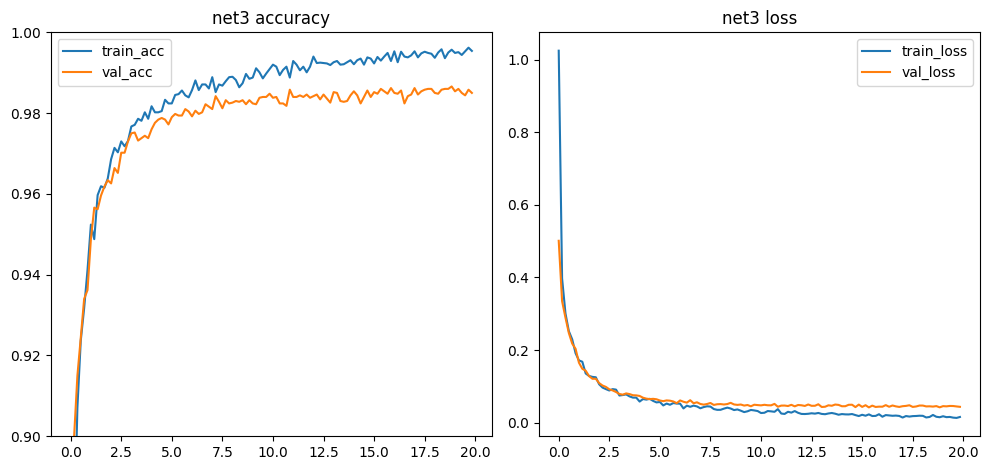

final loss: train 1.0248079243302346 v eval 0.39723885416984556
final acc: train 0.9954000115394592 v eval 0.9850000143051147


In [14]:
fig, ax = plt.subplots(1, 2)
eval_per_epoch = 6

ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [train_acc[0] / train_acc[1] for train_acc in train_accs], label='train_acc')
ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [val_acc[0] / val_acc[1] for val_acc in val_accs], label='val_acc')
ax[0].set_ylim(0.9, 1.)
ax[0].set_title('net3 accuracy')
ax[0].legend()

ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], train_loss, label='train_loss')
ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], val_loss, label='val_loss')
# ax[1].set_ylim(0.0, 1.)
ax[1].set_title('net3 loss')

fig.set_figwidth(10)

plt.tight_layout()
plt.legend()
plt.show()

final_acc = (train_accs[-1], val_accs[-1])
final_loss = (train_loss[-1], val_loss[-1])

print(f"final loss: train {train_loss[0]} v eval {train_loss[1]}")
print(f"final acc: train {final_acc[0][0] / final_acc[0][1]} v eval {final_acc[1][0] / final_acc[1][1]}")

In [12]:
with torch.no_grad():
    test_acc = (0, 0)
    for j, (test_X, test_y) in enumerate(test_loader):
        # evaluation loss and accuracy check
        output = net3(test_X)
        test_acc = tuple(a + b for a, b in zip(test_acc, accuracy(output, test_y)))

print(f" test accuracy: {100 * test_acc[0] / test_acc[1]}")

 test accuracy: 99.5999984741211


Minimal overfitting. Great results.

Vanishing gradient detection?